# BASELINE MODEL

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy as np
import scipy
import sys
from scipy import io
import math
import random
import keras
from sklearn import preprocessing
from glob import glob
import tqdm
from keras.utils import plot_model
import itertools
from sklearn.metrics import confusion_matrix

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 12]
plt.style.use('ggplot')

# GLOBALS

In [2]:
POET_DIR = "D:/data/POETdataset/"
PATCHES_FILE = os.path.join(POET_DIR, "x.npy")
LABELS_FILE = os.path.join(POET_DIR, 'y.npy')
pascal_images = os.path.join(POET_DIR, 'PascalImages')
PATCH_SIZE = 32
HALF_PATCH = PATCH_SIZE//2
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
MAX_GAZE_POINTS = 3 # TEMPORARY
MIN_GAZE_POINTS = 3
VGG_NR_FEATURES = 512
user_index = 0 # TEMPORARY
BATCH_SIZE = 50
IMG_SIZE = 224

In [3]:
os.chdir(POET_DIR)

# DATA 

In [4]:
classes = [a.split("_")[1].split(".mat")[0] for a in glob("etData/*")]
idx2class = {i:c for i, c in enumerate(classes)}
class2idx = {c:i for i, c in enumerate(classes)}

In [5]:
learned_model = keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='max')
pp_func = keras.applications.resnet50.preprocess_input

features_extractor_model = keras.models.Sequential()
features_extractor_model.add(keras.layers.Lambda(pp_func,name='preprocessing',input_shape=(IMG_SIZE,IMG_SIZE,3)))
features_extractor_model.add(learned_model)


## We store the feature vectors for each image

In [6]:
classes

['aeroplane',
 'bicycle',
 'boat',
 'cat',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'sofa']

In [7]:
test_ids = np.load("test_ids.pkl")
train_ids = np.load("train_ids.pkl")

In [8]:
x_train = []
x_test = []
y_train = []
y_test = []
for i, cname in enumerate(tqdm.tqdm(classes)):
    print(cname)
    class_files = glob("PascalImages/%s*" %cname)
    class_files = [os.path.abspath(f) for f in class_files]
    class_files_test = [f for f in class_files if f.split(os.path.sep)[-1] in test_ids]
    class_files_train = [f for f in class_files if f.split(os.path.sep)[-1] in train_ids]
    class_test_instances = len(class_files_test)
    class_train_instances = len(class_files_train)
    files_loaded = [keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(file_, target_size=(IMG_SIZE, IMG_SIZE, 3))
    ) 
                    for file_ in np.concatenate([class_files_train, class_files_test])
                   ]
    feature_vec = features_extractor_model.predict(np.array(files_loaded),verbose=1)
    x_train.append(feature_vec[:class_train_instances])
    x_test.append(feature_vec[class_train_instances:])
    y_train.append([class2idx[cname]]*class_train_instances)
    y_test.append([class2idx[cname]]*class_test_instances)
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)
                                                           

  0%|                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

aeroplane
666/666 [==============================] - 10s 14ms/step


 10%|██████████████▌                                                                                                                                   | 1/10 [00:12<01:54, 12.68s/it]

bicycle
533/533 [==============================] - 5s 9ms/step


 20%|█████████████████████████████▏                                                                                                                    | 2/10 [00:20<01:30, 11.31s/it]

boat
504/504 [==============================] - 5s 9ms/step


 30%|███████████████████████████████████████████▊                                                                                                      | 3/10 [00:28<01:11, 10.15s/it]

cat
1048/1048 [==============================] - 9s 9ms/step


 40%|██████████████████████████████████████████████████████████▍                                                                                       | 4/10 [00:42<01:08, 11.45s/it]

cow
295/295 [==============================] - 3s 10ms/step


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 5/10 [00:47<00:47,  9.40s/it]

diningtable
474/474 [==============================] - 4s 9ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6/10 [00:54<00:34,  8.61s/it]

dog
1254/1254 [==============================] - 11s 9ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7/10 [01:12<00:34, 11.42s/it]

horse
476/476 [==============================] - 5s 10ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8/10 [01:19<00:20, 10.19s/it]

motorbike
499/499 [==============================] - 5s 9ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9/10 [01:26<00:09,  9.40s/it]

sofa
382/382 [==============================] - 4s 10ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  8.36s/it]


In [9]:
len(train_ids), len(test_ids)

(5517, 614)

In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5517, 2048), (5517,), (614, 2048), (614,))

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
enc = OneHotEncoder()
y_train = y_train.reshape(-1,1)
enc.fit(y_train)
y_train = enc.transform(y_train)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [13]:
enc = OneHotEncoder()
y_test = y_test.reshape(-1,1)
enc.fit(y_test)
y_test = enc.transform(y_test)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# MODEL

In [14]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=128, activation='relu', input_shape=(2048,)))
model.add(keras.layers.Dense(units=10, activation='softmax'))
optm = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
                optimizer=optm,
                metrics=['accuracy'],)

In [15]:
import time

timestamp = "%.0f" %time.time()
model_id = "baseline-%s" %(timestamp)
os.mkdir(model_id)

filepath=os.path.join(model_id,"weights.hdf5")
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=15,
                              verbose=0, mode='auto')

In [16]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    verbose=1,
#     batch_size=64,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Train on 5517 samples, validate on 614 samples
Epoch 1/50
5517/5517 [==============================] - 2s 406us/step - loss: 6.5536 - acc: 0.5528 - val_loss: 6.0421 - val_acc: 0.5928

Epoch 00001: val_acc improved from -inf to 0.59283, saving model to baseline-1545578065\weights.hdf5
Epoch 2/50
5517/5517 [==============================] - 1s 145us/step - loss: 4.7645 - acc: 0.6688 - val_loss: 4.8015 - val_acc: 0.6612

Epoch 00002: val_acc improved from 0.59283 to 0.66124, saving model to baseline-1545578065\weights.hdf5
Epoch 3/50
5517/5517 [==============================] - 1s 144us/step - loss: 3.1752 - acc: 0.7392 - val_loss: 0.7199 - val_acc: 0.7915

Epoch 00003: val_acc improved from 0.66124 to 0.79153, saving model to baseline-1545578065\weights.hdf5
Epoch 4/50
5517/5517 [==============================] - 1s 144us/step - loss: 0.5189 - acc: 0.8410 - val_loss: 0.5324 - val_acc: 0.8371

Epoch 00004: val_acc improved from 0.79153 to 0.83713, saving model to baseline-1545578065\weigh

In [17]:
matplotlib.rcParams['figure.figsize'] = [12, 12]

# Plot history

In [ ]:
os.rename(model_id, "%s-acc %.4f" %(model_id, np.max(history.history['val_acc'])))

model_id = "%s-acc %.4f" %(model_id, np.max(history.history['val_acc']))

saving summary to  baseline-1545578065-acc 0.8958-acc 0.8958\summary.txt


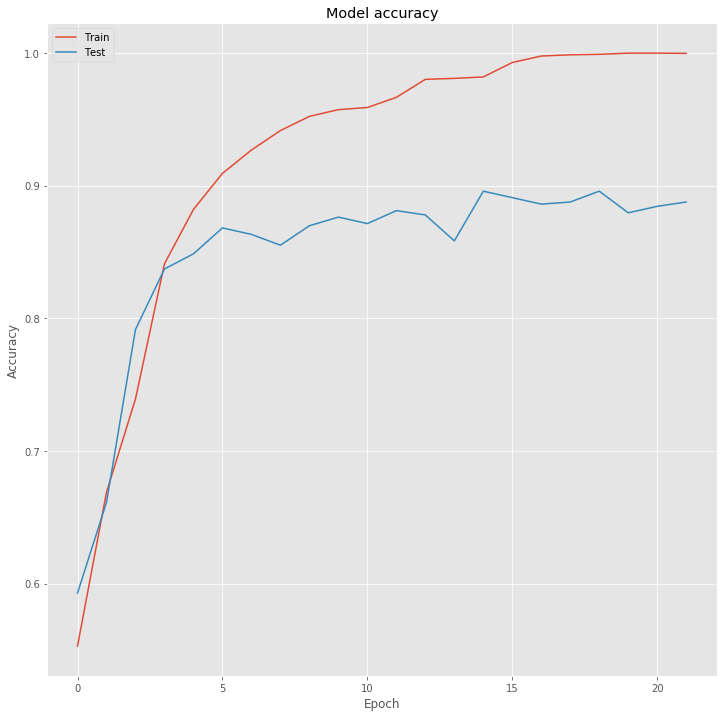

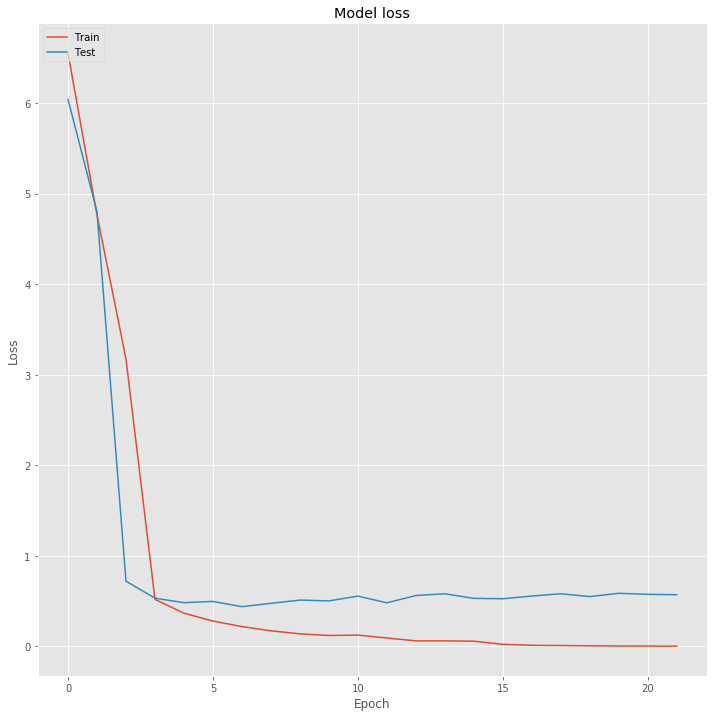

Normalized confusion matrix


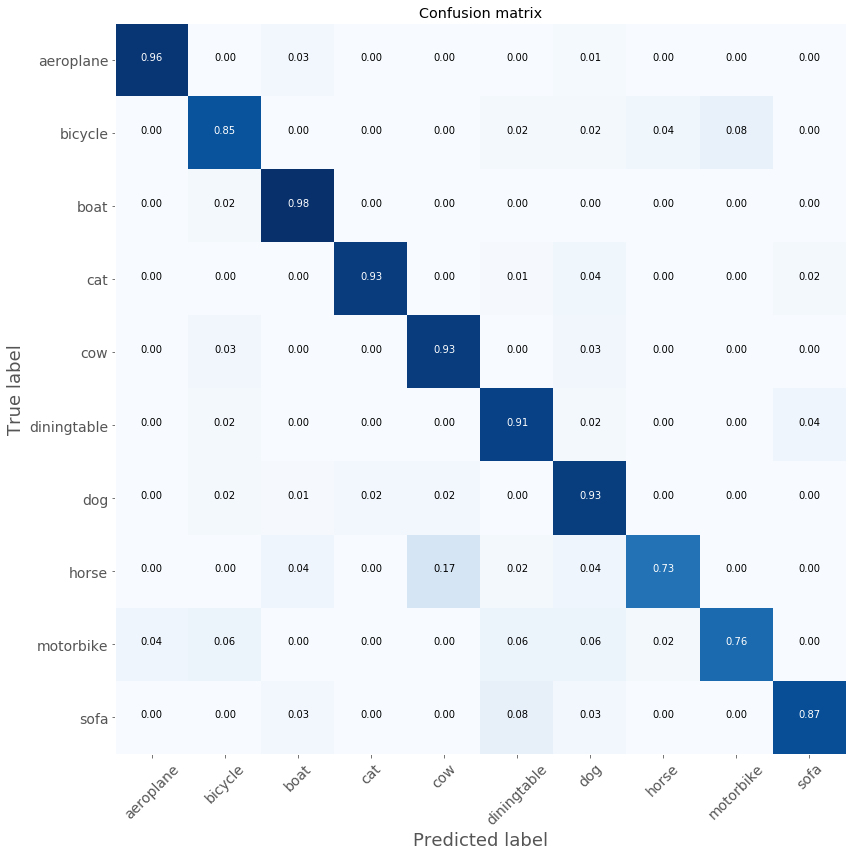

In [23]:
model.load_weights(os.path.join(model_id,"weights.hdf5"))


plot_model(model, to_file=os.path.join(model_id, 'model.png'), show_shapes=True)

total_summary=""

def add_to_summary(line):
    global total_summary
    total_summary += "%s\n" %line

def savesummary():
    global total_summary
    path = os.path.join(model_id, "summary.txt")
    with open(path,'w') as f:
        f.writelines(total_summary)
        f.writelines("\nBest acc : %s" %np.max(history.history['val_acc']))
    print('saving summary to ', path)

model.summary(print_fn=add_to_summary)
savesummary()

# Plot model history

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.gcf().savefig(os.path.join(model_id, "accuracy.png"))
plt.show()
plt.clf()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(os.path.join(model_id, "loss.png"))
plt.show()

# Confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()
    plt.grid(False)
    return plt.gcf()


y_pred_proba = model.predict(x_test)

y_pred = np.argmax(y_pred_proba, axis=1)

y_test_argmax = np.argmax(y_test, axis=1)

y_test_argmax.shape

cnf_matrix = confusion_matrix(y_test_argmax, y_pred)


fig = plot_confusion_matrix(cnf_matrix, class2idx.keys(), normalize=True)


np.save(os.path.join(model_id, 'model-cnf_matrix'), cnf_matrix)
fig.savefig(os.path.join(model_id, 'model-cnf_matrix.png'), bbox='tight')



# Comparison

In [19]:
cnf_matrix_model = np.load(os.path.join("2-150-acc 0.9186",'model-cnf_matrix.npy'))

FileNotFoundError: [Errno 2] No such file or directory: '2-150-acc 0.9186\\model-cnf_matrix.npy'

In [ ]:
cnf_matrix

In [ ]:
cnf_matrix_model

In [ ]:
diff_cnf_matrix = np.abs(cnf_matrix - cnf_matrix_model)

In [ ]:
plot_confusion_matrix(diff_cnf_matrix, class2idx.keys())